In [1]:
import tensorflow as tf
from tensorflow.python import keras #for some reason PyCharm doesn't detect tensorflow.keras (idk why)
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image

In [2]:
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input

vgg = VGG19(include_top=False) #we only need the convolutional layers

In [26]:
def load_img(path):
    max_dim = 512
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    new_shape = tf.cast(tf.shape(img)[:-1] * max_dim/max(tf.shape(img)), dtype=tf.int32)#rescale image to 512
    img = tf.image.resize(img, new_shape)
    
    
    return img[tf.newaxis, :] #vgg requires batched input

def imshow(image, title=None):
    if len(tf.shape(image)) > 3:
        image = tf.squeeze(image, axis=0)
    plt.imshow(image)
    if title:
        plt.title(title)
     

In [27]:
def layer_models(layers):
    vgg = VGG19(include_top=False)
    vgg.trainable = False
    
    outputs = [vgg.get_layer(layer).output for layer in layers]
    return tf.keras.Model(vgg.inputs, outputs)

In [28]:
def gram_matrix(tensor):
    temp = tf.linalg.einsum('ijka, ijkb->iab', tensor, tensor)
    return temp/tf.cast(tf.shape(tensor)[1] * tf.shape(tensor)[2], tf.float32) #loss is relative to 

In [29]:
class StyleTransfer(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleTransfer, self).__init__()
        self.vgg = layer_models(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False
    def call(self, inputs):
        inputs = inputs*255.0
        preprocessed_inputs = preprocess_input(inputs)
        outputs = self.vgg(preprocessed_inputs)
        style_outputs = outputs[:self.num_style_layers]
        content_outputs = outputs[self.num_style_layers:]
        
        style_outputs = [gram_matrix(style) for style in style_outputs]
        
        style_dictionary = {style : output for style, output in zip(self.style_layers, style_outputs)}
        content_dictionary = {content : output for content, output in zip(self.content_layers, content_outputs)}
        
        return {"style" : style_dictionary, "content" : content_dictionary}
    
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [58]:
#Identify style and content layers
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

#Content and style images
content_image = load_img("nighthawks.jpg")
style_image = load_img("Vassily_Kandinsky,_1913_-_Composition_7.jpg")

extractor = StyleTransfer(style_layers, content_layers)

perfect_style = extractor(style_image)["style"]
perfect_content = extractor(content_image)["content"]

In [59]:
image = tf.Variable(content_image)

opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

style_weight = 1e-2
content_weight = 1e4
variation_weight = 30

def style_content_loss(outputs):
    style_outputs = outputs["style"]
    content_outputs = outputs["content"]
    
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[layer] - perfect_style[layer])**2) for layer in style_outputs.keys()])
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[layer] - perfect_content[layer])**2) for layer in content_outputs.keys()])
    
    style_loss *= style_weight/len(style_outputs.keys())
    content_loss *= content_weight/len(content_outputs.keys())
    
    return style_loss + content_loss

def variation_loss(outputs):
    x_var = image[:,:,1:,:] - image[:,:,:-1,:]
    y_var = image[:,:,:,1:] - image[:,:,:,:-1]
    return tf.reduce_sum(tf.abs(x_var)) + tf.reduce_sum(tf.abs(y_var))

In [60]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += variation_weight * variation_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  clipped = clip_0_1(image)
  image.assign(clipped)

In [61]:
train_step(image)

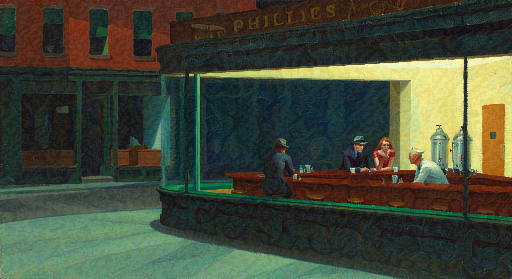

In [62]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

tensor_to_image(image)

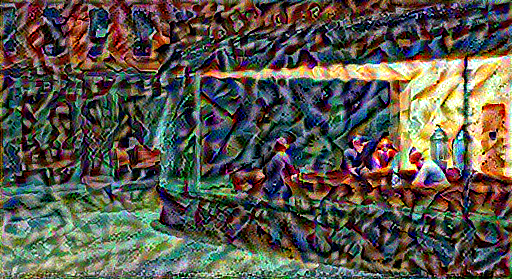

In [63]:
for i in range(100):
    train_step(image)
tensor_to_image(image)